In [1]:
#pip install chess
import chess
import math
import time
import chess.svg
import time
import numpy as np
from IPython.display import display, HTML, clear_output

In [2]:
##evaluation function  ##if piece.color =True, piece is white, otherwise black
##piece_type: pawn:1, knight:2, bishop:3, rook:4,queen:5,king:6
def get_piece_value(piece):
    if piece.color:
        color_factor = 1;
    else:
        color_factor = -1;
    if piece.piece_type == 1:
        return 1.0 * color_factor
    elif piece.piece_type == 2:
        return 3.0 * color_factor
    elif piece.piece_type == 3:
        return 3.0 * color_factor
    elif piece.piece_type == 4:
        return 5.0 * color_factor
    elif piece.piece_type == 5:
        return 9.0 * color_factor
    elif piece.piece_type == 6:
        return 0 * color_factor

def materials(board,weight):
        scores = 0.0
        for i in range(8):
            for j in range(8):
                if board.piece_at(chess.square(i,j)):
                    piece = board.piece_at(chess.square(i,j))
                    scores += get_piece_value(piece)
        return scores*weight 

def get_square_at_position(position):
    """
    Square position sanitizer for when either a string
    or chess.Square can be entered as a position
    Args:
        position( Union[str, chess.Square])
    Returns:
        (chess.Square)
    """
    # Convert from string to chess.square via characters in string
    if isinstance(position, str):
        file, rank = ord(position[0].lower()) - 97, int(position[1]) - 1
        square = chess.square(file, rank)
    elif isinstance(position, chess.Square):
        square = position

    return square

def get_piece_at(
    board: chess.Board, position):
    """
    Gets chess symbol of piece at position on board
    Args:
        board (chess.Board): current board state in python-chess object
        position (str/chess.Square): position of square i.e chess.A1 or "A1"
    Returns:
        (str): symbol of piece at square if any
    """
    # Convert position to chess.Square
    square = get_square_at_position(position)
    piece = board.piece_at(square)

    if piece:
        return piece.symbol()
    return ""

def piece_moves(board, weight):
    scores = 0
    square_values = {"e4": 1, "e5": 1, "d4": 1, "d5": 1, "c6": 0.5, "d6": 0.5, "e6": 0.5, "f6": 0.5,
                    "c3": 0.5, "d3": 0.5, "e3": 0.5, "f3": 0.5, "c4": 0.5, "c5": 0.5, "f4": 0.5, "f5": 0.5}
    possible_moves =board.legal_moves
    for move in possible_moves:
        if board.turn:
            if str(move)[2:4] in square_values:
                scores += square_values[str(move)[2:4]]
        else:
            if str(move)[2:4] in square_values:
                scores -= square_values[str(move)[2:4]]
    return scores * weight

def in_check(board, weight):
    scores = 0 
    # Turn should be 'w' or 'b'
    # Check or Checkmate situations
    if board.turn == "w":
        if board.is_checkmate():
            scores -= 9999.0
        elif  board.is_check():
            scores -= weight
    else:
        if board.is_checkmate():
            scores += 9999.0
        elif board.is_check():
            scores += weight
    return scores

pawntable = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]
knightstable = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]
bishopstable = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]
rookstable = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]
queenstable = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]
kingstable = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]

def piece_score(board,weight):
    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq= sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq= bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])
    score = pawnsq + knightsq + bishopsq + rooksq + queensq +kingsq
    return score*weight

#pawn:1, knight:2, bishop:3, rook:4,queen:5,king:6

def MVV_LVA(board):
    piece_values = {"P":1,"N":3,"B":3,"R":5,"Q":9,"K":25}
    available_captures = {}#: Dict[int,List[chess.Move]]
    move_list = list(board.legal_moves)
    # For each move, evaluate if any captures. If so, rank captures based
    # off value gained
    for move in move_list:
        if board.is_capture(move):
            aggressor_piece = get_piece_at(board, str(move)[:2]).upper()
            victim_piece = get_piece_at(board, str(move)[2:]).upper()
            if aggressor_piece and victim_piece:
                value_diff = (
                    piece_value[victim_piece].value
                    - piece_value[aggressor_piece].value
                )
                available_captures[value_diff] = move

    # If any available captures, sort captures by value_diff of captures
    # and return list of sorted captures
    if available_captures:
        move_list_sorted = []
        for val_diff in sorted(available_captures, reverse=True):
            move_list_sorted.append(available_captures[val_diff])
        return move_list_sorted

    # If no captures, return shuffled list of all legal moves
    random.shuffle(move_list)
    return move_list

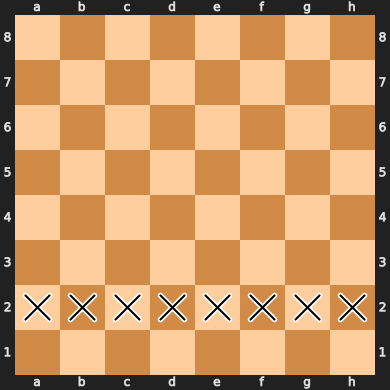

In [3]:
board1 = chess.Board()
board1.pieces(chess.PAWN, chess.WHITE)

In [4]:
def who(player):
    return "White" if player == chess.WHITE else "Black"
def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>" 

In [5]:
def play_game(player1, player2, board, visual="svg", pause=0.5):
    """
    playerN1, player2: functions that takes board, return uci move
    visual: "simple" | "svg" | None
    """
    use_svg = (visual == "svg")
    
    #board = chess.Board()
    try:
        while not board.is_game_over(claim_draw=True):
            if board.turn == chess.WHITE:
                #time1 = time.time()
                uci = player1(board)
                #timetaken = time.time() - time1
                #timetaken_.append(timetaken)
            else:
                uci = player2(board)               
            name = who(board.turn)
            board.push_uci(uci)
            board_stop = display_board(board, use_svg)
            html = "<b>Move %s %s, Play '%s':</b><br/>%s" % (
                       len(board.move_stack), name, uci, board_stop)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (None, msg, board)
    result = None
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        result = not board.turn
    elif board.is_stalemate():
        msg = "draw: stalemate"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
    elif board.can_claim_draw():
        msg = "draw: claim"
    if visual is not None:
        print(msg)
    return (result, msg, board)

In [6]:
import random
def random_player(board):
    move = random.choice(list(board.legal_moves))
    return move.uci()

In [7]:
def human_player(board):
    #display(board)
    uci = get_move("%s's move [q to quit]> " % who(board.turn))
    legal_uci_moves = [move.uci() for move in board.legal_moves]
    while uci not in legal_uci_moves:
        print("Legal moves: " + (",".join(sorted(legal_uci_moves))))
        uci = get_move("%s's move[q to quit]> " % who(board.turn))
    return uci

In [8]:
def get_move(prompt):
    uci = input(prompt)
    if uci and uci[0] == "q":
        raise KeyboardInterrupt()
    try:
        chess.Move.from_uci(uci)
    except:
        uci = None
    return uci

In [9]:
def get_heuristic(board):
    scores = 0
    scores += materials(board,100)
    scores += piece_moves(board,1)
    scores += in_check(board,5)
    scores += piece_score(board,10)
    return scores

In [10]:
def compMove_prune(board):
    possible_moves = list(board.legal_moves)
    alpha = -9999
    beta = 9999
    bestScore = -9999
    best_move = possible_moves[0]
    for move in possible_moves:
        newboard = board.copy()
        newboard.push(move)
        score = ab_minimax(newboard,alpha,beta,1,False)
        newboard = board.copy()
        if score > bestScore:
            bestScore = score
            bestMove = move
    return bestMove.uci()

In [11]:
def ab_minimax(board,alpha,beta,depth,isMaximizing):
    max_depth= 3 
    moves = list(board.legal_moves)
    if board.is_checkmate():
        if board.turn: ##it is white turn
            return -9999
        else:
            return 9999
    if depth == max_depth:
        return get_heuristic(board)
    if isMaximizing:
        best_score = -9999
        for move in moves:
            newboard = board.copy()
            newboard.push(move)
            score = ab_minimax(newboard,alpha,beta,depth+1, False)
            newboard = board.copy()
            alpha = max(alpha,best_score)
            best_score = max(best_score, score)
            if beta <= alpha:
                return best_score
        return best_score
    else:
        best_score = 9999
        for move in moves:
            newboard = board.copy()
            newboard.push(move)
            score = ab_minimax(newboard,alpha,beta,depth+1, True)
            newboard = board.copy()
            beta = min(beta,best_score)
            best_score = min(best_score, score)
            if beta <= alpha:
                return best_score
        return best_score

In [12]:
#Performance against Engine? 
import chess.engine

In [14]:
engine = chess.engine.SimpleEngine.popen_uci("/usr/bin/stockfish")
board = chess.Board()
limit = chess.Engine.Limit(time=2.0)
play_game(compMove_prune, engine.play, board)

FileNotFoundError: [WinError 2] The system cannot find the file specified

# Depth Evaluation with time

In [15]:
#For time evaluation
def Average(lst):
    return sum(lst) / len(lst)

## At Depth = 1 

In [16]:
board = chess.Board()
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

ZeroDivisionError: division by zero

In [ ]:
#Saving times/ results from 5 itterations 
Times = [0.018729, 0.017422, 0.025268, 0.017828] #5 anomolous 0.018544s
Moves = [39, 57, 67, 51] #result 5 completed CM in 23 moves, taken as anomolous
Scores = [13599, 14399, 15299, 13099, 12749]
T = Average(Times)
print(T)
M = Average(Moves)
print(M)
S = Average(Scores)
print(S)

## At Depth = 2

In [ ]:
board = chess.Board()
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

In [ ]:
#Saving times/ results from 5 itterations 
Times = [0.392013, 0.399719, 0.428960, 0.378561, 0.339441]
Moves = [39, 49, 41, 33, 29]
Scores = [13249, 13499, 14599, 14299, 13749]
T = Average(Times)
print(T)
M = Average(Moves)
print(M)
S = Average(Scores)
print(S)

# At Depth = 3

In [ ]:
board = chess.Board()
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

In [ ]:
#Saving times/ results from 5 itterations 
Times = [2.981667, 3.264843, 3.233584, 2.629634, 4.634122]
Moves = [27, 27, 29, 29, 43] 
Scores = [11799, 12699, 12099, 13699, 12949]
T = Average(Times)
print(T)
M = Average(Moves)
print(M)
S = Average(Scores)
print(S)

# At Depth = 4

In [ ]:
board = chess.Board()
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

In [ ]:
timetaken_

In [ ]:
#Saving times/ results from 5 itterations 
Times = [41.936947, 48.255630, 44.060638, 34.604875, 35.082485]
Moves = [25, 31, 25, 31, 23]
Scores = [12599, 13549, 13299, 12949, 12099]
T = Average(Times)
print(T)
M = Average(Moves)
print(M)
S = Average(Scores)
print(S)

# Variable Depth- not saved

In [ ]:
board = chess.Board() #5depth
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

In [ ]:
timetaken_

In [ ]:
board = chess.Board() #6Depth
timetaken_ = []
play_game(compMove_prune, random_player, board)
A = Average(timetaken_)
H = get_heuristic(board)
print(A)
print(H)

In [ ]:
timetaken_

# Human Player Scenarios

## Yaz (1668)

In [ ]:
#playing against a depth 4 Minimax
board2 = chess.Board()
board2
play_game(compMove_prune, human_player, board2)

In [ ]:
#playing against a depth 3 Minimax
board2 = chess.Board()
board2
play_game(compMove_prune, human_player, board2)

## Playing Against Stockfish lvl 1 (800)

In [20]:
#Depth 1- wins (1/1)
board = chess.Board()
board
play_game(compMove_prune, human_player, board)

(None,
 'Game interrupted!',
 Board('rnbqkb1r/pppppppp/5n2/8/8/2N2N2/PPPPPPPP/R1BQKB1R b KQkq - 3 2'))

## Playing Against Stockfish lvl 2 (1100)

In [ ]:
#Depth 1- Wins (1/1)
board = chess.Board()
board
play_game(compMove_prune, human_player, board)

## Playing Against Stockfish lvl 3 (1400)

In [ ]:
#Depth 1- Loses (1/1)
board = chess.Board()
board
play_game(compMove_prune, human_player, board)

In [ ]:
#Depth 2- Loses (1/1)  
board = chess.Board()
board
play_game(compMove_prune, human_player, board)

In [13]:
#Depth 3- Wins (2/5), Loses (3/5)
#generally wins when Stockfish blunders; e.g. does not capture queen when should 
board = chess.Board()
board
play_game(compMove_prune, human_player, board)

UnboundLocalError: local variable 'bestMove' referenced before assignment

In [ ]:
#Depth 4- Wins (), Loses ()
board = chess.Board()
board
play_game(compMove_prune, human_player, board)